In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf

import sys
sys.path.append('..')

import metrics

import warnings
warnings.filterwarnings('once')

In [2]:
def MASE(x, y, p):
    nom = np.mean(np.abs(y - p), axis=1)
    denom = np.mean(np.abs(x[:, 1:] - x[:, :-1]), axis=1) + np.finfo('float').eps
    return nom / denom

def SMAPE(y, p):
    nom = np.abs(y - p)
    denom = np.abs(y) + np.abs(p) + np.finfo('float').eps
    return 2 * np.mean(nom / denom, axis=1) * 100

def OWA(x, y, p):
    rel_smape = SMAPE(y, p) / 15.201
    rel_mase = MASE(x, y, p) / 1.685
    return (rel_smape + rel_mase) / 2

In [3]:
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

In [4]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [5]:
def get_last_12(series):
    return series.dropna().iloc[-12:].values

In [6]:
X_test = np.array([get_last_12(ser[1]) for ser in train.iterrows()])
y_test = test.values

In [31]:
def get_predictions(model, X):
    
    preds = []
    
    for i in range(len(X) // 256):
        x = X[i * 256:(i+1) * 256]

        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)

        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis]) 
        preds.append(pred[..., 0] * (mx - mn) + mn)

    x = X[(i+1) * 256:]
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1) 
    x_sc = (x - mn) / (mx - mn)
    pred = model(x_sc[..., np.newaxis]) 
    preds.append(pred[..., 0] * (mx - mn) + mn)
    

    return np.vstack(preds)

In [14]:
p = Path('../results').absolute()

In [15]:
trials = list(p.glob('*'))
trial_names = [t.name for t in trials]

In [16]:
results = {'smape': {k: [] for k in trial_names},
           'mase': {k: [] for k in trial_names},
           'owa': {k: [] for k in trial_names}}

for trial in tqdm(trials):
    model_dir = str(trial / 'best_weights.h5')
    
    mape = metrics.build_mape(overlap=6)
    smape = metrics.build_smape(overlap=6)
    mase_estimate = metrics.build_mase(overlap=6)
    owa_estimate = metrics.build_owa(overlap=6)
    reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

    model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                  'MASE_estimate': mase_estimate,
                                                                  'OWA_estimate': owa_estimate,
                                                                  'reconstruction_loss': reconstruction_loss})
    
    preds = get_predictions(model, X_test)
    
    tf.keras.backend.clear_session()
    
    results['smape'][trial.name].append(np.nanmean(SMAPE(y_test, preds[:, 6:])))
    results['mase'][trial.name].append(np.nanmean(MASE(X_test, y_test, preds[:, 6:])))
    results['owa'][trial.name].append(np.nanmean(OWA(X_test, y_test, preds[:, 6:])))


  0%|          | 0/203 [00:00<?, ?it/s]/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':

  0%|          | 1/203 [00:12<41:42, 12.39s/it]/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':

  1%|          | 2/203 [00:18<35:10, 10.50s/it]

KeyboardInterrupt: 

In [54]:
def create_results_df(results, ensemble=False):
    new_keys = [k for k in results['smape'].keys() if not k.isdigit()]
    columns = ['input_len', 'output_len', 'loss', 'bottleneck_size',
               'bottleneck_activation', 'LSTM_type', 'num']
    if ensemble:
        columns.pop()
        
    df = pd.DataFrame([k.split('__') for k in new_keys],
                   columns=columns)
    
    for column in ('input_len', 'output_len', 'loss',
                    'bottleneck_size', 'bottleneck_activation',
                    'LSTM_type'):
        
        df[column] = df[column].apply(lambda x: x.split('_')[1])
            
    df['smape'] = [results['smape'][k][0] if results['smape'][k] else np.nan for k in new_keys]
    df['mase*'] = [results['mase'][k][0] if results['mase'][k] else np.nan for k in new_keys]
    
    return df

In [55]:
df = create_results_df(results)

In [56]:
df.sort_values('smape')

,input_len,output_len,loss,bottleneck_size,bottleneck_activation,LSTM_type,num,smape,mase*
83,12,12,mae,50,leaky,bi,5,13.150599,2.463560
21,12,12,mae,50,relu,bi,1,13.204066,2.486077
104,12,12,mae,100,leaky,bi,3,13.220715,2.488784
53,12,12,mae,25,tanh,bi,2,13.222986,2.488183
56,12,12,mae,25,relu,bi,3,13.223019,2.485225
...,...,...,...,...,...,...,...,...,...
41,12,12,mae,50,leaky,uni,3,13.638560,2.610401
27,12,12,mae,25,leaky,uni,7,13.648280,2.520414
91,12,12,mae,50,relu,bi,4,13.747935,2.573454
114,12,12,mae,25,tanh,uni,3,13.784612,2.611486


In [42]:
df.groupby(['loss', 'bottleneck_size', 'bottleneck_activation', 'LSTM_type'])['smape'].mean()

loss  bottleneck_size  bottleneck_activation  LSTM_type
mae   100              leaky                  bi           13.385511
                                              uni          13.374092
      25               leaky                  bi           13.434750
                                              uni          13.485872
                       relu                   bi           13.356209
                                              uni          13.486923
                       tanh                   bi           13.407217
                                              uni          13.395098
      50               leaky                  bi           13.381620
                                              uni          13.458044
                       relu                   bi           13.383894
                                              uni          13.394240
                       tanh                   bi           13.342429
                                              u

In [23]:
df.to_csv('../reports/result_df.csv', index=False)

### 10 models median

In [15]:
trial_families = [t.name[:-3] for t in trials if t.name[0] == 'i']

results_median = {'smape': {k: [] for k in trial_families},
                  'mase': {k: [] for k in trial_families},
                  'owa': {k: [] for k in trial_families}}

for family in tqdm(trial_families):
    
    family_preds = []
    for num in range(10):
        print(family, num)
        model_dir = str(trials[0].parent / '__'.join([family, str(num)]) / 'best_weights.h5')
        print(model_dir)
        mape = metrics.build_mape(overlap=6)
        smape = metrics.build_smape(overlap=6)
        mase_estimate = metrics.build_mase(overlap=6)
        owa_estimate = metrics.build_owa(overlap=6)
        reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

        model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                      'MASE_estimate': mase_estimate,
                                                                      'OWA_estimate': owa_estimate,
                                                                      'reconstruction_loss': reconstruction_loss})

        model_preds = get_predictions(model, X_test)

        family_preds.append(model_preds)
        tf.keras.backend.clear_session()
    
    preds = np.median(np.array(family_preds), axis=0)
    
    results_median['smape'][family].append(np.nanmean(SMAPE(y_test, preds[:, 6:])))
    results_median['mase'][family].append(np.nanmean(MASE(X_test, y_test, preds[:, 6:])))
    results_median['owa'][family].append(np.nanmean(OWA(X_test, y_test, preds[:, 6:])))

  0%|          | 0/135 [00:00<?, ?it/s]

inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  1%|          | 1/135 [02:09<4:50:14, 129.96s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  1%|▏         | 2/135 [03:13<4:04:01, 110.08s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  2%|▏         | 3/135 [04:17<3:31:54, 96.32s/it] 

inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  3%|▎         | 4/135 [06:30<3:54:15, 107.29s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  4%|▎         | 5/135 [08:40<4:06:51, 113.93s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  4%|▍         | 6/135 [10:48<4:14:16, 118.27s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  5%|▌         | 7/135 [12:57<4:19:19, 121.56s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  6%|▌         | 8/135 [14:03<3:41:55, 104.85s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  7%|▋         | 9/135 [16:13<3:56:08, 112.45s/it]

inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  7%|▋         | 10/135 [18:23<4:04:52, 117.54s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  8%|▊         | 11/135 [20:32<4:09:53, 120.92s/it]

inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
  9%|▉         | 12/135 [22:42<4:13:40, 123.74s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_leaky__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 10%|▉         | 13/135 [23:45<3:34:42, 105.59s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 10%|█         | 14/135 [25:53<3:46:17, 112.21s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 11%|█         | 15/135 [28:01<3:54:01, 117.02s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 12%|█▏        | 16/135 [29:04<3:19:57, 100.82s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_relu__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 13%|█▎        | 17/135 [30:07<2:55:56, 89.46s/it] 

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 13%|█▎        | 18/135 [32:14<3:16:31, 100.79s/it]

inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 14%|█▍        | 19/135 [34:23<3:30:51, 109.07s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 15%|█▍        | 20/135 [36:30<3:39:47, 114.67s/it]

inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_25__bkact_tanh__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 16%|█▌        | 21/135 [37:33<3:08:24, 99.16s/it] 

inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_relu__dir_bi__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 16%|█▋        | 22/135 [39:41<3:23:02, 107.81s/it]

inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__5/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 6
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__6/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 7
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__7/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 8
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__8/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni 9
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_50__bkact_leaky__dir_uni__9/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
 17%|█▋        | 23/135 [40:45<2:56:19, 94.46s/it] 

inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni 0
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__0/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni 1
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__1/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni 2
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__2/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni 3
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__3/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni 4
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__4/best_weights.h5


/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni 5
/home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__5/best_weights.h5


OSError: SavedModel file does not exist at: /home/thanos/projects/ae_pred/analysis/../results/inp_12__out_12__loss_mae__bksize_100__bkact_leaky__dir_uni__5/best_weights.h5/{saved_model.pbtxt|saved_model.pb}

In [57]:
med = create_results_df(results_median, ensemble=True)

In [59]:
med.to_csv('../results/median_result_df.csv')

In [11]:
def m4_smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.nanmean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()


def m4_mase(insample, y_test, y_hat_test, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])

    masep = np.mean(abs(insample[freq:] - y_hat_naive))

    return np.nanmean(abs(y_test - y_hat_test)) / masep

In [12]:
m4_smape(y_test, preds[:, 6:])

0.1353691322553586

In [13]:
m4_mase(X_test, y_test, preds[:, 6:], 6)

0.25680578088560957

### fix nan

In [14]:
np.where(np.isnan(preds))

(array([15087, 15087, 15087, 15087, 15087, 15087, 15087, 15087, 15087,
        15087, 15087, 15087]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

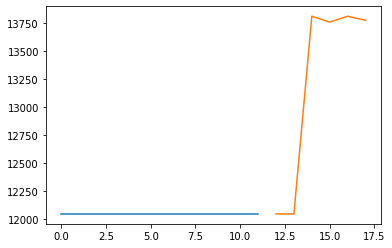

In [15]:
plt.plot(range(12), X_test[15087])
plt.plot(range(12, 18), y_test[15087])

In [16]:
preds_fixed = preds.copy()

In [17]:
preds_fixed[15087] = X_test[15087, -1]

In [18]:
np.any(np.isnan(preds_fixed))

False

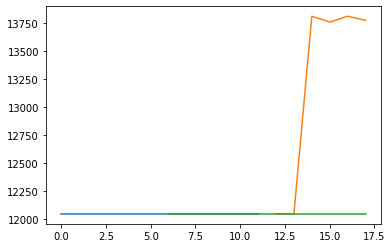

In [19]:
plt.plot(range(12), X_test[15087])
plt.plot(range(12, 18), y_test[15087])
plt.plot(range(6, 18), preds_fixed[15087])

In [20]:
def m4_smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()


def m4_mase(insample, y_test, y_hat_test, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])

    masep = np.mean(abs(insample[freq:] - y_hat_naive))

    return np.mean(abs(y_test - y_hat_test)) / masep

In [22]:
m4_mase(X_test, y_test, preds_fixed[:, 6:], 6)

0.2568097820044437

### find best

In [26]:
smapes = [s[0] for s in results['smape'].values() if s]
mases = [s[0] for s in results['mase'].values() if s]

In [27]:
np.argmin(smapes)

37

In [28]:
np.argmin(mases)

9

In [31]:
smapes[37], mases[37]

(13.175348506531154, 2.473241526273387)

In [32]:
smapes[9], mases[9]

(13.211644733815417, 2.470802343828664)

In [39]:
model_dir = 'results/37/best_weights.h5'

model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                              'MASE_estimate': mase_estimate,
                                                              'OWA_estimate': owa_estimate,
                                                              'reconstruction_loss': reconstruction_loss})

best_preds = get_predictions(model, X_test)

/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [47]:
best_preds[15087] = X_test[15087, -1]

In [58]:
np.savetxt('m4_predictions.csv', best_preds[:, 6:], delimiter=',')

In [81]:
smapes = [m4_smape(y_test[i], best_preds[i, 6:]) for i in range(len(y_test))]

In [82]:
np.mean(smapes)

0.1317516584416001